In [1]:
%load_ext autoreload
%autoreload 2
import terra
from domino.train import train_model, score_model, score_settings, train_settings

In [4]:
from domino.train import train_model, score_model, score_settings, train_settings

In [9]:
setting_dp = score_settings.out().load()
setting_dp[
    [
        "target_synset",
        "slice_synsets",
        "in_slice_0_recall_mean",
        "out_slice_recall_mean",
        "train_model_run_id",
        "score_model_run_id",
    ]
]

,target_synset (PandasSeriesColumn),slice_synsets (ListColumn),in_slice_0_recall_mean (PandasSeriesColumn),out_slice_recall_mean (PandasSeriesColumn),train_model_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn)
0,musical_instrument.n.01,['pipe.n.04'],tensor(0.8410),tensor(0.8260),13160,13195
1,musical_instrument.n.01,['brass.n.02'],tensor(0.5764),tensor(0.5071),13162,13196
2,vehicle.n.01,['streetcar.n.01'],tensor(0.9577),tensor(0.8716),13164,13197
3,vehicle.n.01,['aircraft_carrier.n.01'],tensor(0.9639),tensor(0.8836),13166,13198
4,vehicle.n.01,['motorcycle.n.01'],tensor(0.9019),tensor(0.8948),13168,13199
5,food.n.01,['cup.n.06'],tensor(0.4834),tensor(0.8533),13170,13200
6,musical_instrument.n.01,['flute.n.01'],tensor(0.6927),tensor(0.7799),13172,13201
7,bird.n.01,['swan.n.01'],tensor(0.8633),tensor(0.8253),13174,13202
8,musical_instrument.n.01,['piano.n.01'],tensor(0.8223),tensor(0.7945),13176,13203
9,bird.n.01,['duck.n.01'],tensor(0.9439),tensor(0.8439),13178,13204


In [11]:
data_dp = train_model.inp(13170)["dp"].load()

In [16]:
data_dp.lz[data_dp["target"] == 1]["slices"].mean()

0.029973860005808886

In [ ]:
run_id = 13125
score_dp = score_model(
    dp=train_model.inp(run_id)["dp"],
    model=train_model.get(run_id, "best_chkpt")["model"],
    split="test",
    batch_size=128
)

In [78]:
run_id = 13119

pred_dp = train_model.get(run_id, "best_chkpt")["valid"].load()
pred_dp = pred_dp[["preds", "ids"]].merge(
    train_model.inp(run_id)["dp"].load(), left_on="ids", right_on="image_id"
)
pred_dp["output"] = pred_dp["preds"]

In [79]:
from domino.metrics import compute_model_metrics
compute_model_metrics(pred_dp, num_iter=10)

{'overall': {'auroc': {'mean': 0.8601272503011065,
   'lower': 0.8573372963647847,
   'upper': 0.8667068185235799},
  'recall': {'mean': tensor(0.6491),
   'lower': 0.6480917066335679,
   'upper': 0.6656080663204194},
  'precision': {'mean': 0.3099525128611001,
   'lower': 0.30591115947764147,
   'upper': 0.31572022160664814}},
 'in_slice_0': {'auroc': nan,
  'recall': {'mean': tensor(0.6020),
   'lower': 0.5454081416130067,
   'upper': 0.6586734533309937},
  'precision': {'mean': 1.0, 'lower': 1.0, 'upper': 1.0}},
 'out_slice': {'auroc': {'mean': 0.8601838968169614,
   'lower': 0.8557697163308524,
   'upper': 0.8633561517743218},
  'recall': {'mean': tensor(0.6505),
   'lower': 0.6378259807825089,
   'upper': 0.662261927127838},
  'precision': {'mean': 0.3070929070929071,
   'lower': 0.3017382617382618,
   'upper': 0.3141008991008991}}}

In [32]:
train_model.inp(run_id)

{'dp': {'__run_dir__': '/home/sabri/terra/slice/tasks/slices/abstract/build_setting/_runs/13124', '__key__': 'dc5c9481e8704ad0afc305f131c9a190', '__type__': <class 'meerkat.datapanel.DataPanel'>, '__id__': 197077},
 'setting_config': {'dataset': 'imagenet',
  'n': {'__run_dir__': '/home/sabri/terra/slice/tasks/train/train_model/_runs/13125', '__key__': '19cc5792e02b4079ae7c576181acaa71', '__type__': <class 'numpy.int64'>, '__id__': 197078},
  'slice_category': 'rare',
  'slice_frac': 0.029999999999999995,
  'slice_synsets': ['grain.n.07'],
  'target_frac': 0.20876288659793815,
  'target_synset': 'fruit.n.01',
  'index': '196',
  'setting_id': {'__run_dir__': '/home/sabri/terra/slice/tasks/train/train_model/_runs/13125', '__key__': '47c8a17ca8bb4c1fa6ce9e4042de9267', '__type__': <class 'numpy.int64'>, '__id__': 197079}},
 'model_config': {'pretrained': False},
 'run_dir': '/home/sabri/terra/slice/tasks/train/train_model/_runs/13125',
 'pbar': False,
 'batch_size': 128,
 'val_check_inter

In [64]:
from domino.evaluate import run_sdm
inp = run_sdm.inp(run_id=12602, load=True)
emb_dp = inp["emb_dp"]

data_dp = pred_dp.merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)
data_dp["pred"] = pred_dp["output"][:, -1]


In [73]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=25, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "valid"])

100%|██████████| 100/100 [00:22<00:00,  4.52it/s]
/home/sabri/code/domino/domino/sdm/gmm.py:263: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [74]:
from domino.metrics import compute_sdm_metrics
slice_idx = 0

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(by="auroc", ascending=False)

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
2,2,0,0.987893,1.0,0.92,0.65,0.35,0.541667,0.775000,1.0,0.027254
1,1,0,0.796766,0.0,0.00,0.00,0.00,0.000000,0.033333,0.0,0.000000
3,3,0,0.233418,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000
0,0,0,0.213726,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000
4,4,0,0.196863,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000


In [76]:
from domino.emb.clip import embed_words
pred_slice_idx = 2
words_dp = embed_words.out(5143).load().lz[:int(1.1e4)]
expl_dp = sdm.explain(words_dp=words_dp, data_dp=dp)
expl_dp.lz[(-expl_dp["pred_slices"][:, pred_slice_idx]).argsort()[:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn),frequency (PandasSeriesColumn)
0,mask,"np.ndarray(shape=(5,))",26830
1,mexico,"np.ndarray(shape=(5,))",233978
2,mexican,"np.ndarray(shape=(5,))",108138
3,folklore,"np.ndarray(shape=(5,))",21701
4,hispanic,"np.ndarray(shape=(5,))",63226
5,guatemala,"np.ndarray(shape=(5,))",22652
6,nicaragua,"np.ndarray(shape=(5,))",14814
7,peru,"np.ndarray(shape=(5,))",48509
8,ecuador,"np.ndarray(shape=(5,))",26980
9,teatro,"np.ndarray(shape=(5,))",12999


,image_id (PandasSeriesColumn),preds (TensorColumn),ids (PandasSeriesColumn),path (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),name (PandasSeriesColumn),synset_pos_offset (PandasSeriesColumn),synset (PandasSeriesColumn),target (NumpyArrayColumn),slices (NumpyArrayColumn),input (ImageColumn),id (PandasSeriesColumn),split (PandasSeriesColumn),output (TensorColumn),emb (NumpyArrayColumn),pred (TensorColumn),pred_slices (NumpyArrayColumn)
0,n03724870_5271,torch.Tensor(shape=torch.Size([2])),n03724870_5271,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_5271.JPEG,826063,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_5271,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.1365),"np.ndarray(shape=(5,))"
1,n03724870_15011,torch.Tensor(shape=torch.Size([2])),n03724870_15011,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_15011.JPEG,825223,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_15011,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.8241),"np.ndarray(shape=(5,))"
2,n03724870_723,torch.Tensor(shape=torch.Size([2])),n03724870_723,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_723.JPEG,826172,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_723,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.5514),"np.ndarray(shape=(5,))"
3,n03724870_2319,torch.Tensor(shape=torch.Size([2])),n03724870_2319,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_2319.JPEG,825648,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_2319,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.4129),"np.ndarray(shape=(5,))"
4,n03724870_11944,torch.Tensor(shape=torch.Size([2])),n03724870_11944,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_11944.JPEG,825073,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_11944,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.8904),"np.ndarray(shape=(5,))"
5,n03724870_9621,torch.Tensor(shape=torch.Size([2])),n03724870_9621,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_9621.JPEG,826274,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_9621,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.1942),"np.ndarray(shape=(5,))"
6,n03724870_2990,torch.Tensor(shape=torch.Size([2])),n03724870_2990,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_2990.JPEG,825793,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_2990,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.5415),"np.ndarray(shape=(5,))"
7,n03724870_11634,torch.Tensor(shape=torch.Size([2])),n03724870_11634,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_11634.JPEG,825060,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_11634,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.1005),"np.ndarray(shape=(5,))"
8,n03724870_43805,torch.Tensor(shape=torch.Size([2])),n03724870_43805,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_43805.JPEG,825962,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_43805,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.5944),"np.ndarray(shape=(5,))"
9,n03724870_21805,torch.Tensor(shape=torch.Size([2])),n03724870_21805,/home/common/datasets/imagenet/ILSVRC/Data/CLS-LOC/train/n03724870/n03724870_21805.JPEG,825598,,mask,n03724870,mask.n.01,1,"np.ndarray(shape=(1,))",,n03724870_21805,valid,torch.Tensor(shape=torch.Size([2])),"np.ndarray(shape=(512,))",tensor(0.7644),"np.ndarray(shape=(5,))"

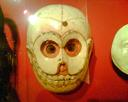
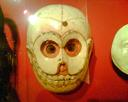
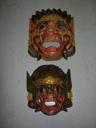
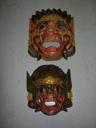
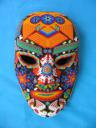
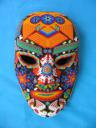
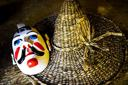
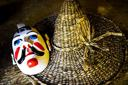
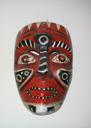
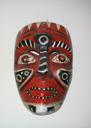
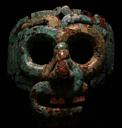
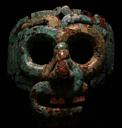
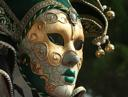
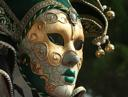
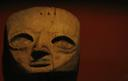
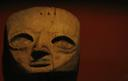
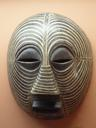
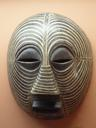
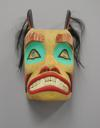
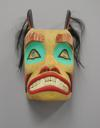

In [77]:
dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]]#[["object_image", "target", "slice"]]